# 0 - Définition des données

In [22]:
from tensorflow.keras import datasets, layers, models
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

import numpy as np

(x_train,y_train),(x_test,y_test) = datasets.fashion_mnist.load_data()

labels = [

def preprocess(imgs):
    imgs = imgs.astype("float32")/255.0
    imgs = np.pad(imgs, ((0,0), (2,2), (2,2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

# transformation des images de 28x28 en 32x32
x_train = preprocess(x_train)
x_test = preprocess(x_test)

# 1 - Définition de l'encodeur

In [9]:
encoder_input = layers.Input(shape=(32,32,1), name='encoder_input')
x = layers.Conv2D(32, (3,3), strides=2, activation='relu', padding='same')(encoder_input)
x = layers.Conv2D(64, (3,3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3,3), strides=2, activation='relu', padding='same')(x)

# conservation de la forme pour la reconstruction
# on s'attend à reshape [None,4,4,128]
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
encoder_output = layers.Dense(2, name="encoder_output")(x)
encoder = models.Model(encoder_input, encoder_output)

# 2 - Définition du décodeur

In [12]:
decoder_input = layers.Input(shape=(2,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3,3), strides = 2, activation = 'relu', padding = 'same')(x)
x = layers.Conv2DTranspose(64, (3,3), strides = 2, activation = 'relu', padding = 'same')(x)
x = layers.Conv2DTranspose(32, (3,3), strides = 2, activation = 'relu', padding = 'same')(x)
decoder_output = layers.Conv2D(1, (3,3), strides = 1, activation = 'sigmoid', padding = 'same', name = "decoder_output" )(x)

decoder = models.Model(decoder_input, decoder_output)

# 3 - Définition du modèle

In [14]:
autoencoder = models.Model(encoder_input, decoder(encoder_output))
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

# 4 - Entraînement du modèle

In [16]:
# On entraîne le modèle sur ses propres images en boucle
autoencoder.fit( x_train, x_train, epochs = 5, batch_size = 100, shuffle = True, validation_data = (x_test, x_test) )

Epoch 1/5


2024-08-30 07:22:47.204294: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 245760000 exceeds 10% of free system memory.
2024-08-30 07:22:47.503440: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 245760000 exceeds 10% of free system memory.


600/600 [==============================] - 85s 141ms/step - loss: 0.2931 - val_loss: 0.2641
Epoch 2/5
600/600 [==============================] - 84s 140ms/step - loss: 0.2591 - val_loss: 0.2575
Epoch 3/5
600/600 [==============================] - 84s 140ms/step - loss: 0.2553 - val_loss: 0.2553
Epoch 4/5
600/600 [==============================] - 84s 140ms/step - loss: 0.2529 - val_loss: 0.2540
Epoch 5/5
600/600 [==============================] - 85s 141ms/step - loss: 0.2517 - val_loss: 0.2531


# 5 - Reconstruction

In [25]:
sample_imgs = x_test[:5000]
predictions = autoencoder.predict(sample_imgs)

157/157 [==============================] - 2s 15ms/step


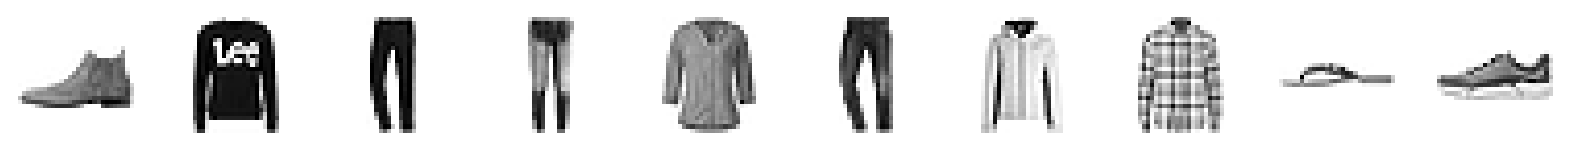

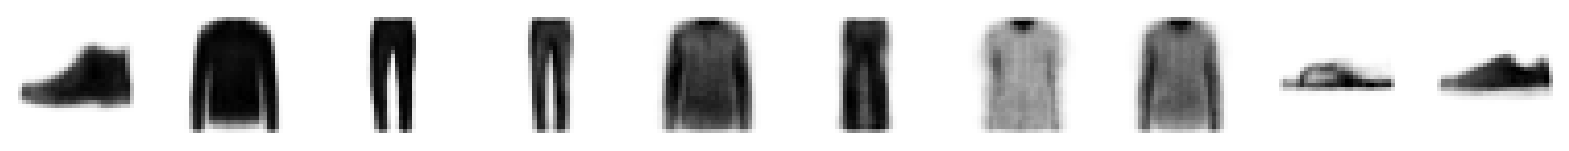

In [46]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")
        

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

display(sample_imgs)
display(predictions)

# Affichage de l'espace latent

157/157 [==============================] - 1s 4ms/step


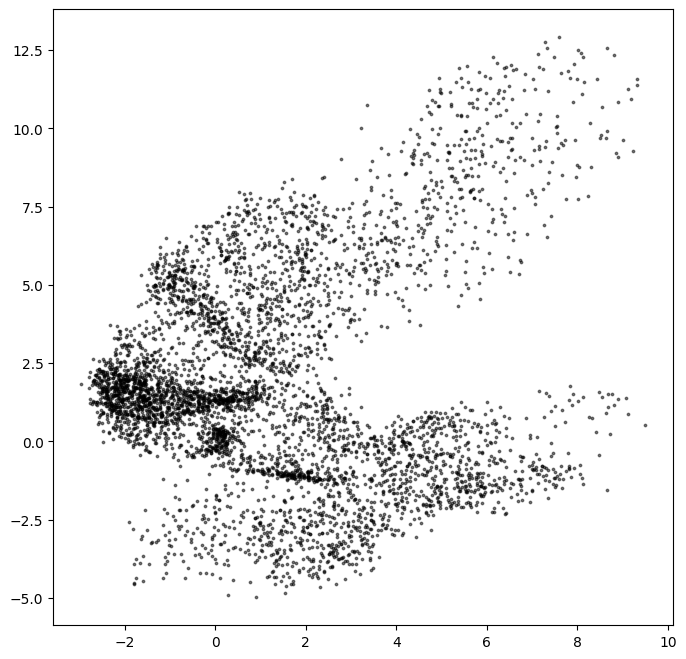

In [33]:
embeddings = encoder.predict(sample_imgs)

plt.figure(figsize=(8,8))
plt.scatter(embeddings[:,0], embeddings[:,1], c="black", alpha=0.5, s=3)
plt.show()


[9 2 1 ... 9 0 7]


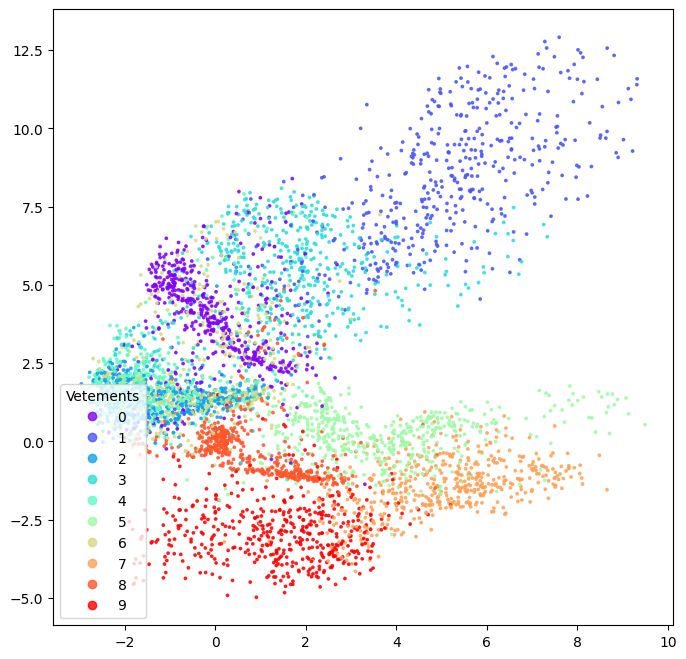

In [44]:
example_labels = y_test[:5000]

figsize = 8
fig = plt.figure(figsize=(figsize, figsize))
scatter = plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
ax = fig.axes[0]
legend = ax.legend(*scatter.legend_elements(), loc="lower left", title="Vetements")
print(example_labels)
#plt.colorbar()
#plt.show()

# Génération d'images grâce à des coordonnées aléatoires depuis l'espace latent

1/1 [==============================] - 0s 107ms/step


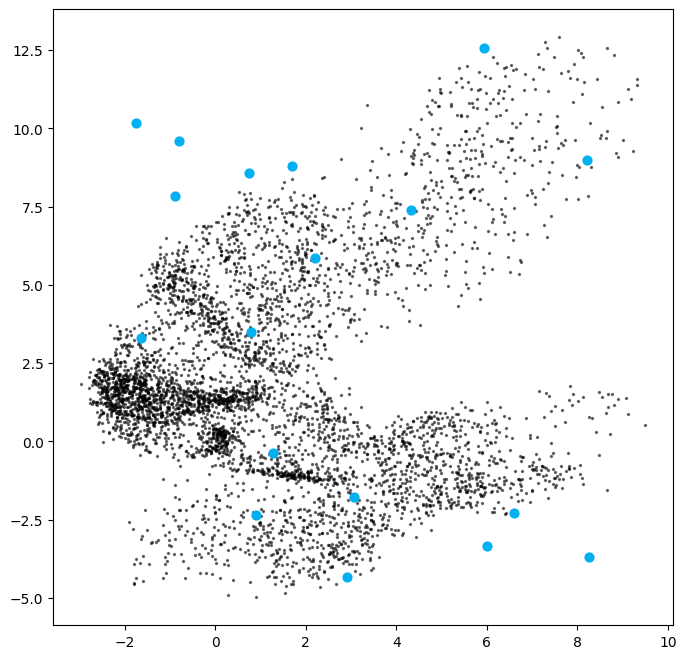

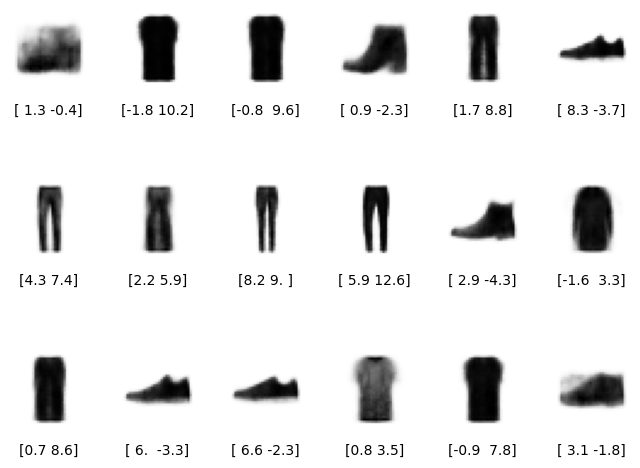

In [49]:
# Get the range of the existing embeddings
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Sample some points in the latent space
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, 2)
)

reconstructions = decoder.predict(sample)

# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

# Superposition de l'espace latent avec l'espace de réalisation

8/8 [==============================] - 0s 13ms/step


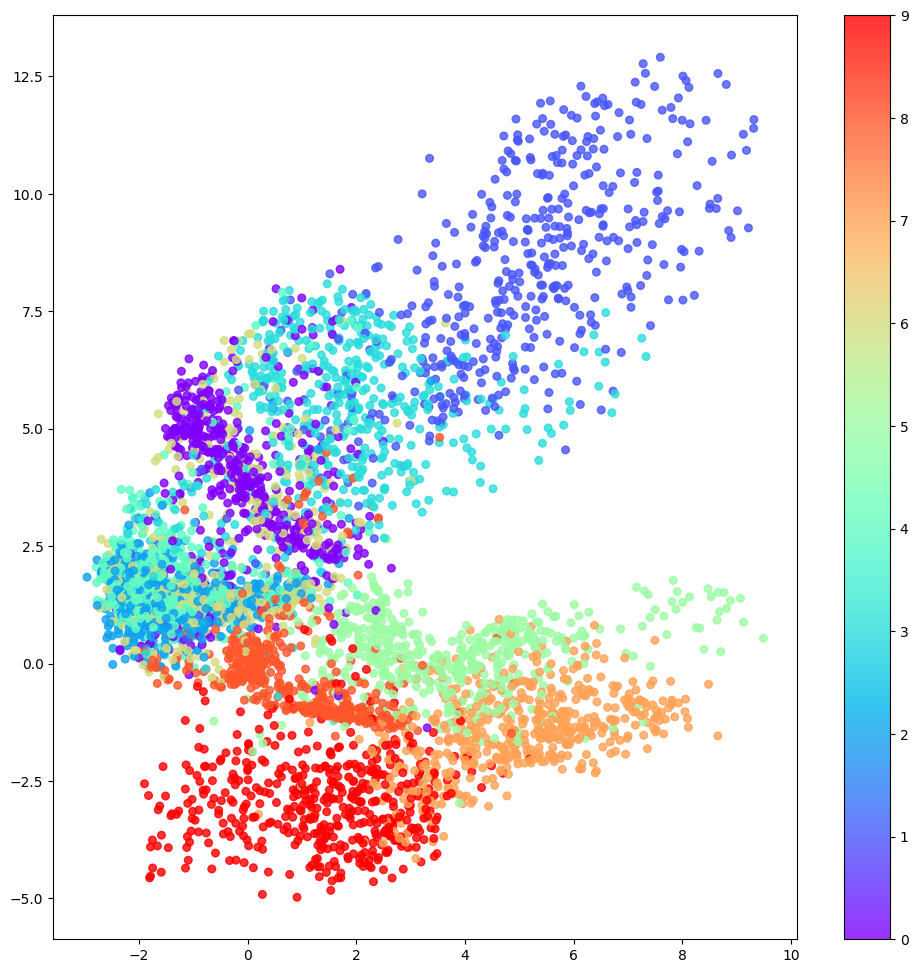

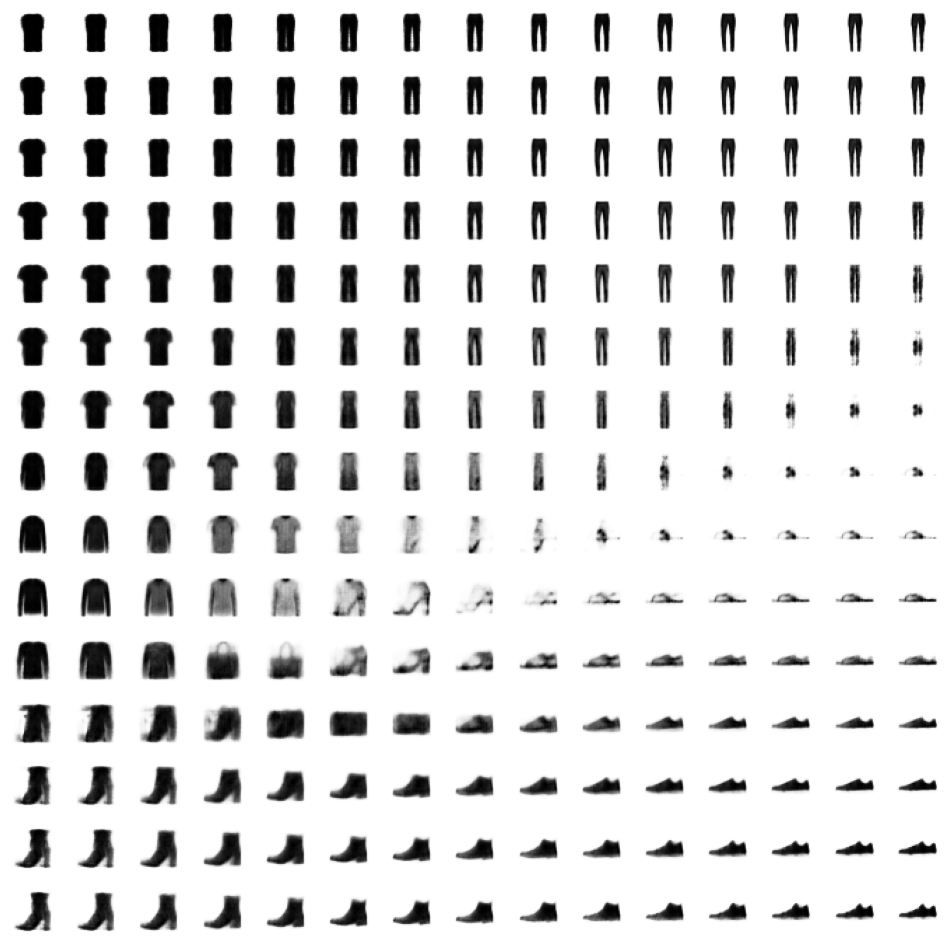

In [51]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=30,
)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")